In [1]:
import Bioneural as bn
import sys,getopt
import re
import numpy as np

# load config
def read_info():
    data=[]
    chem=[]
    seq=[]
    combined=[]
    for line in open("Config.txt","r"): 
        data.append(line)
    for i in data:
        if re.match('MolecularStructuresNeuralNetworks:',i):
            info=np.squeeze(re.findall('MolecularStructuresNeuralNetworks:(\w*),\[(.*)\],(.*),(.*),(.*),(.*),(.*)',i))
            number=re.split(r',',info[1])
            number=[int(i) for i in number]
            chem = {'Type' : info[0], 'Neuron' : number,'Optimizer' : info[2], 'InitializationMethod' : info[3],'Output_type':info[4] ,'Batch_size':int(info[5]),'Epoch':int(info[6])}
        elif re.match('AminoAcidSequencesNeuralNetworks:',i):
            info=np.squeeze(re.findall('AminoAcidSequencesNeuralNetworks:(\w*),\[(.*)\],(.*),(.*),(.*),(.*),(.*),(.*)',i))
            number=re.split(r',',info[1])
            number=[int(i) for i in number]
            seq = {'Type' : info[0], 'Neuron' : number,'Optimizer' : info[2], 'InitializationMethod' : info[3],'Dropout_rate':float(info[4]),'Output_type':info[5],'Batch_size':int(info[6]),'Epoch':int(info[7])}
        elif re.match('CombinedNeuralNetworks:',i):
            
            info=np.squeeze(re.findall('CombinedNeuralNetworks:\[(.*)\],(.*),(.*),(.*),(.*)',i))
            number=re.split(r',',info[0])
            number=[int(i) for i in number]
            combined = { 'Neuron' :number,'Optimizer' : info[1], 'InitializationMethod' : info[2],'Batch_size':int(info[3]),'Epoch':int(info[4])}
    return chem,seq,combined

# load linux shell parameters
def get_para():
    opts,args = getopt.getopt(sys.argv[1:], "i:o:s:t:")
    input_file=""
    output_file=""
    input_file_solubility=""
    input_file_thermostability=""
    for op, value in opts:
        if op == "-i":
            input_file = value
        elif op == "-s":
            input_file_solubility = value
        elif op == "-t":
            input_file_thermostability = value
        elif op == "-o":
            output_file = value
            #path=set_path(output_file)
        elif op == "-h":
            usage()
            sys.exit()
    return input_file,output_file,input_file_solubility,input_file_thermostability

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The frequency is: Counter({'L': 89702, 'A': 73834, 'E': 61872, 'R': 57930, 'V': 56902, 'G': 55558, 'S': 51514, 'I': 47854, 'D': 45246, 'T': 42578, 'Q': 38524, 'K': 37728, 'P': 36804, 'F': 31266, 'N': 29856, 'Y': 26454, 'H': 24564, 'M': 20344, 'W': 10678, 'C': 9980, 'X': 12})
Amino acids type is: 21
They are: dict_keys(['M', 'V', 'I', 'S', 'Q', 'L', 'T', 'K', 'E', 'G', 'R', 'Y', 'D', 'P', 'H', 'F', 'A', 'N', 'W', 'C', 'X'])


D:\Anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


The original vector shape:
(2552, 1024, 4)
The flattened vector shape:
 (2552, 4096)
There are 1276 soluble chemicals (positive samples) and 1276 insoluble chemicals (negative samples).


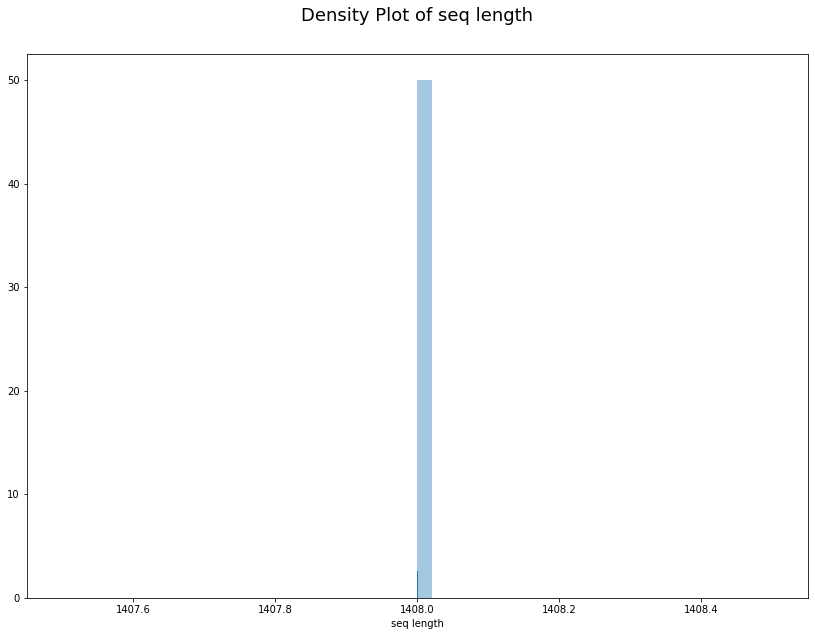

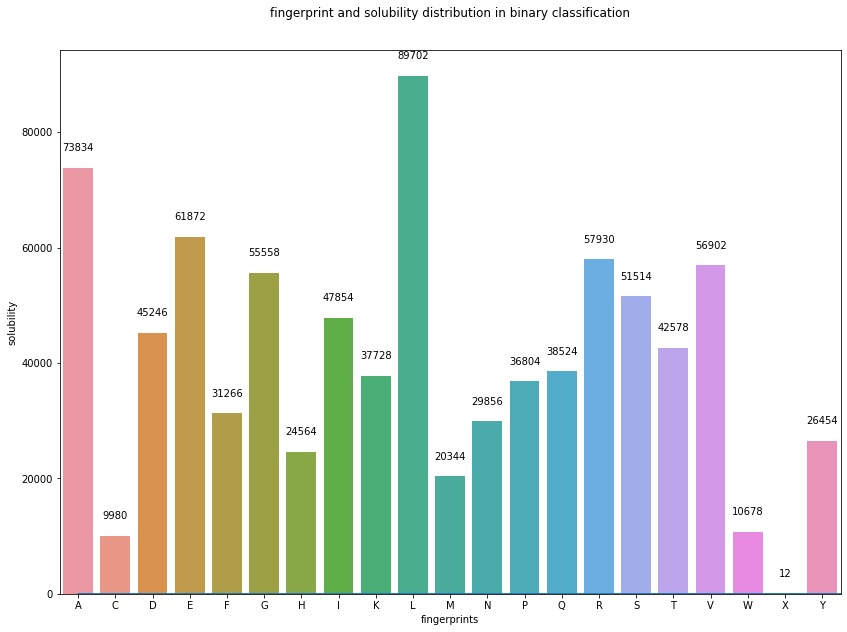

The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (1144, 4096)
There are 587 soluble chemicals (positive samples) and 557 insoluble chemicals (negative samples).


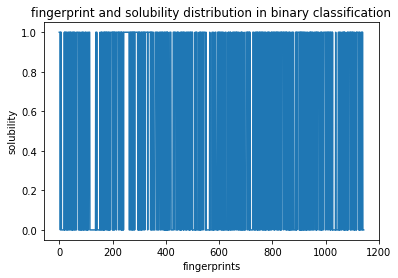

The mean of the seq length is: 1408.0
The S.D. of the seq length is: 0.0


D:\Anaconda\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [132]:
"""Main"""
path=bn.set_path("./result")

# python Biosensor_NN_Transfer_Learning.py -i biosensor_seqs.csv -o F:/result/ -s delaney.csv
"""Load Data"""
chem,seq,combined=read_info()
cv=bn.load_biosensor("biosensor_seqs.csv",".")
#Load processed biosensor data
Train_seq,Train_chemical,Label,d_to_index=bn.load_processed_biosensor(cv,"biosensor_seqs.csv",".")
X_chem,Y_chem_hardmax=bn.load_solubility("delaney.csv","./result")
bn.visu_KDE(Train_seq,"seq length",path+'Density Plot of seqs length.svg')

In [65]:
# Generate vocab for BERT
from collections import Counter
tmp=""
for i in cv.seq:
    tmp = tmp + str(i)
c2 = Counter(tmp)
keys=""
for i in c2.keys():
    keys=keys+str(i)
keys="[UNK][CLS][SEP][MASK]" + keys
f2 = open('vocab.txt','r+')
f2.write(keys)
f2.close()
"""WRITE CONTEXT"""
from keras.preprocessing.sequence import pad_sequences
unpad=[]
for i in list(cv.seq):
    unpad.append(list(i))
pad=pad_sequences(unpad, maxlen=256, dtype='object',padding='pre', truncating='pre', value=0.)
for p,i in enumerate(pad):
    for q,j in enumerate(i):
        if j ==0.0:
            pad[p][q]="0"
#context
padded=[]
for i in pad:
    tex=""
    for j in i: 
        tex=tex+str(j)
    padded.append(tex)

f=open("cortext.txt",'w')
#f.write(str(list))
for i in padded:
    f.write(str(i)+'\r\n')  #\r\n为换行符
f.close()
"""Pre-training"""
#  max_seq_length * masked_lm_prob 30
! python ./bert/create_pretraining_data.py \ --input_file=./cortext.txt \ --output_file=./result/pretrained_model.tfrecord \ --vocab_file=./vocab.txt \ --do_lower_case=True \ --max_seq_length=256 \ --max_predictions_per_seq=38 \  --masked_lm_prob=0.15 \ --random_seed=12345 \ --dupe_factor=5
! python ./bert/run_pretraining.py \ --input_file=./result/pretrained_model.tfrecord \ --output_dir=./result/pretraining_output \ --do_train=True \ --do_eval=True \ --train_batch_size=16 \ --max_seq_length=256 \ --max_predictions_per_seq=38 \  --num_train_steps=600 \ --num_warmup_steps=10 \ --learning_rate=2e-5 \ --bert_config_file=./bert_config.json
! python ./bert/extract_features.py \ --input_file=./cortext.txt \ --output_file=./result/output.jsonl \ --vocab_file=./vocab.txt \ --bert_config_file=./result/bert_config.json \ --init_checkpoint=./result/model.ckpt \ --layers=-1,-2,-3,-4 \ --max_seq_length=256 \ --batch_size=16


In [164]:
from sklearn import datasets
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import model_from_json
import json

embedded=[]
layers = []
# load json and create embedding vectors
with  open('./result/output.jsonl', 'r') as json_file:
    for line in json_file:
        for k in json.loads(line)['features'][0]['layers']:
            layers.append(k['values'])
        embedded.append(np.transpose(layers))
        layers=[]
json_file.close()
cv.seq=embedded
Train_seq=np.array(list(cv.seq))

In [181]:
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
import pandas as pd 
from keras.layers import Bidirectional
from keras.utils import plot_model
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from Bio import SeqIO
from Bio.PDB.Polypeptide import d1_to_index
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
""" Import_packages"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem

## Load Data

""" Read csv file and return it as a panda dataframe(dictionary) by biopython """
def readfasta(ffile):
    """ Read fasta file, return dictionary """
    record_iterator = SeqIO.parse(ffile, "fasta")
    a=pd.DataFrame(columns=['id','seq'])
    for i in record_iterator:
        a.loc[a.shape[0]+1] = [i.id,str(i.seq[:])] 
    return a

""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(properties="Solubility",path="",input_values=None):
    if properties == "Solubility":
        SolubilityData = read_csv(path) # read csv
        chems=[] # variable to store the 

    #     # change column names of 
    #     SolubilityData.rename(columns={ SolubilityData.columns[1]: properties }, inplace=True)
    #     SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    #     SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)

        for row in range(0,len(SolubilityData['SMILES'])):
            chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
        SolubilityData['SMILES'] = chems
        return SolubilityData # return the data list which contains the three input    
    else:
        chems=[] # variable to store the
        for i in  input_values:
            chems.append( Chem.MolFromInchi(i) )
        return chems


""" Visualize seq length and solu """
# plot the histogram of solubility
import re
import seaborn as sns
import os

def visu_KDE(Values,name,path):
    
    if re.search(r'length',str(name)):
        length=[]
        for i in Values:
            length.append(len(i))
        train_y_plot = pd.Series( np.squeeze(length), name=name)
    else:
        train_y_plot = pd.Series( np.squeeze(Values), name=name)
    mean = train_y_plot.mean()
    std = train_y_plot.std()
    print("The mean of the "+name+" is: " + str(mean))
    print("The S.D. of the "+name+" is: " + str(std))
    f,ax= plt.subplots(figsize = (14, 10))
    sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
    ax.set_title("Density Plot of "+name, fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')

from collections import Counter
"""Visualize seq vocab"""
# Count amino acid and convert to vocab
def vis_seq_elements(X_seq,path):
    tmp=""
    for i in X_seq:
        tmp = tmp + str(i)
    c2 = Counter(tmp)
    print("The frequency is: " + str(c2))
    print("Amino acids type is: " + str(len(c2)))
    print("They are: " + str(c2.keys()))
    k = pd.DataFrame.from_dict([c2])
    classes=len(c2.keys())

    f,ax= plt.subplots(figsize = (14, 10))
    g=sns.barplot(data=k,ax=ax)
    for p in g.patches:
            g.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
    ax.set_title("Frequencies Hist of Amino Acids", fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')
    return list(c2.keys())

## Tokenization

"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
def flatten_chem(X_chem):
    
    depth = 4
    fpSize = 1024
    tc = tensorChem(X_chem,fpSize, depth)
    print('The original vector shape:\n'+str(tc.shape))
    # The flattened vector shape
    train_x_flatten = tc.reshape(tc.shape[0], -1)
    print('The flattened vector shape:\n '+str(train_x_flatten.shape))
    return train_x_flatten

def one_hot(seq):
    """ Convert amino acid to one-hot vector stack """
    # Generate amino acids one-hot dict
    to_one_hot = dict()
    for i, a in enumerate(d1_to_index):
        v = np.zeros(len(d1_to_index))
        v[i] = 1
        to_one_hot[a] = v
    ix = []
    result = []
    # Tranfer the seq by the dict
    for m in seq:
        result.append(to_one_hot[m])
    result = np.array(result)
    return np.reshape(result, (1, result.shape[0], result.shape[1]))

def index_seq(seq,vocab):
    """ Convert amino acid to numerical index """
    index=[]
    for i in seq:
        if i in vocab: 
            p=vocab.index(i)
            index.append(p)
        else:
            index.append('?')
    index = index
    return index

def tensor_pad(seqs,vocab,max_length=False):
    # Init seqs vector
    seqs_index=[]
    # Transfer seqs into index vector
    for seq in seqs:
        seqs_index.append(index_seq(seq,vocab))
    # Pad the seqs
    if max_length==False:
        pad=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)
    else:
        pad=pad_sequences(seqs_index, maxlen=max_length, dtype='int32',padding='pre', truncating='pre', value=0.)
#     # one-hot encode the pad
#     encoded = to_categorical(pad)

    #return seqs_index
    return pad

"""Class to seq"""
def catagorite_EC(EC):
    tmp=[]
    for i in EC:
        i=i.split('.')
        for k, a in enumerate(i):
            if re.search(r'n',a):
                a=re.search(r'\d',a)[0]
            i[k]=int(a)
        if len(i)<=3:
            i.append(0)
        tmp.append(i)
    return tmp

"""Class to index"""
from sklearn import preprocessing
def catagorite_EC_index(EC):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(EC)
    EC = encoder.transform(EC)
    num_classes = np.max(EC) + 1

    # Convert labels to one hot
    EC = to_categorical(EC, num_classes)
    return EC

def set_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
def hardmax(Y_b4):
    Y_b4=np.array([int(i) for i in Y_b4.T])
    Y=np.zeros((1,len(Y_b4)))
    mean = Y_b4.mean()
    std = Y_b4.std()
    for i in range(0,len(Y_b4)-1):
        if (Y_b4[i] >=mean):
            Y[0][i]=1
        else:
            Y[0][i]=0

    print('There are '+ str(list(np.squeeze(Y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(Y)).count(0)) + ' insoluble chemicals (negative samples).')

    # plot the input fingerprint length distribution plot
    plt.plot(np.squeeze(Y))
    plt.ylabel('solubility')
    plt.xlabel('fingerprints')
    plt.title("fingerprint and solubility distribution in binary classification" )
    plt.show()
    
    return np.squeeze(Y)

## NN Architecture

"""NN Model"""
from keras import backend as K
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense

# Customized R2 ACC method
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
            
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations)
         
def create_network(layer_type=("LSTM",[4096,32,32,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init',vocab=d1_to_index,drop_out=0.5):
    # Setup hyperparameters for optimizers
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    sgd=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    
    # Start neural network
    network = Sequential()
    if layer_type[0]=="LSTM":
#         network.add(LSTM(32, return_sequences=True, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros'))
#        network.add(Embedding(output_dim=layer_type[1][1], input_dim=len(vocab), input_length=(layer_type[1][0]),embeddings_initializer='uniform'))
        for i in layer_type[1][2:-1]: 
            network.add(LSTM(i, return_sequences=True, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros'))  # returns a sequence of vectors of dimension 32
#         network.add(LSTM(i, return_sequences=True, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros'))  # returns a sequence of vectors of dimension 32
            network.add(Dropout(drop_out))
        #     network.add(LSTM(32))  # return a single vector of dimension 32
        network.add(Flatten())
    elif layer_type[0]=="DFF":
        network.add(layers.Dense(units=layer_type[1][1], activation='relu', input_shape=(layer_type[1][0],),kernel_initializer='he_normal',bias_initializer='zeros'))
        if len(layer_type[1])>=4:
            for i in layer_type[1][2:-1]:
                # Add fully connected layer with a ReLU activation function
                network.add(layers.Dense(units=i, activation='relu'))

    if outputlayer_type=='linear_regression':
        if layer_type[1][-1]!=0:

        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1]))

            # Compile neural network
            if optimizer == 'bgd':
                network.compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                print("Optimizer batch gradient decent; Loss mean_squared_error.")
            elif optimizer == 'Adam':
                network.compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
                print("Optimizer Adam; Loss mean_squared_error.")
            
    elif outputlayer_type=='binary_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1], activation='sigmoid'))

            # Compile neural network
            if optimizer == 'sgd':
                network.compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                print("Optimizer batch gradient decent; binary_crossentropy.")
            elif optimizer == 'Adam':
                network.compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
                print("Optimizer Adam; binary_crossentropy.")
    
    elif outputlayer_type=='multiple_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a softmax activation function
            network.add(Dense(layer_type[1][-1], activation='softmax'))
            # Compile neural network
            if optimizer == 'bgd':
                network.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                print("Optimizer batch gradient decent; Loss mean_squared_error.")
            elif optimizer == 'Adam':
                network.compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
                print("Optimizer Adam; Loss mean_squared_error.")
    
    # Return compiled network
    return network

def combine_models(Seq_NN,Seq_input,Chem_NN,Chem_input):
    Seq_input = Input(shape=(Seq_input,4))
    encoded_seq = Seq_NN(Seq_input)
    Chem_input = Input(shape=(Chem_input,))
    encoded_chem = Chem_NN(Chem_input)
    merged_NN1 = layers.concatenate([encoded_seq, encoded_chem])
    NN1=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(merged_NN1)
    NN2=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(NN1)
    NN3=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(NN2)
    merged_NN =  layers.Dense(units=1,activation='sigmoid')(NN3)
    combined_model = Model([Seq_input, Chem_input], merged_NN)
#     combined_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return combined_model

import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
def confusion_heatmap(Y_seq_EC_tokenized_index,Y_pre_EC,name):

    tmp=[]
    for i in Y_pre_EC:
        num = np.argmax(i)
        tmp.append(num)
    Y_re=[np.argmax(i) for i in Y_seq_EC_tokenized_index]
    Y_re=np.array(Y_re).reshape(np.array(Y_re).shape[0],)
    tmp=np.array(tmp)

    table=pd.crosstab(Y_re,tmp, rownames=['Actual'], colnames=['Predicted'], margins=True)
    table.to_csv(name + "error_map.csv")

    cnf_matrix = confusion_matrix(Y_re, tmp)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=d2_to_index,title='Confusion matrix , without normalization')
    plt.savefig(name + "confusion_heatmap.svg", bbox_inches='tight')
    plt.close()

# Plot linear regression
def linear_regression(Train_Y,Train_Y_pred,Test_Y,Test_Y_pred,path,i):
        r_square=get_r2_statsmodels(Train_Y_pred,Train_Y)
        q_square=get_r2_statsmodels(Test_Y_pred,Test_Y)
        
        # Plot Training-set
        model=LinearRegression()
        model.fit(Train_Y_pred,Train_Y)
        ax=plt.gca()
        plt.scatter(Train_Y_pred,Train_Y)
        y_train_pred=model.predict(Train_Y_pred)
        plt.title('Linear regression of solubility training prediction in fold '+str(i+1))
        plt.text(0.5,0.7,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Train_Y_pred,y_train_pred,color='black',linewidth=3,label="R-square")
        plt.legend(loc=2)
        plt.xlabel("train  (mol/L)")
        plt.ylabel("theorical  (mol/L)")

        # Plot Testing-set
        model=LinearRegression()
        model.fit(Test_Y_pred,Test_Y)

        plt.scatter(Test_Y_pred,Test_Y)
        y_train_pred=model.predict(Test_Y_pred)

        plt.text(0.5,0.645,"The Q-square value is %.2f " % q_square,verticalalignment='bottom',color='red', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Test_Y_pred,y_train_pred,color='red',linewidth=3,label="Q-square")
        plt.legend(loc=2)
        
        plt.savefig(path+'linear_regression_fold_'+str(i+1)+'.svg', bbox_inches='tight')
        plt.close()
        
# Linear regression INFO

class error_ana_info():
    def __init__(self):
        self._train_metric = None
        self._test_metric = None
        self.df = None
        self.mdif = None
    
    def add_info(self,train_metric,test_metric):
        if self._train_metric is None or  self._test_metric is None:
            self._train_metric = np.array(train_metric)
            self._test_metric = np.array(test_metric)
        else:
            self._train_metric = np.vstack((self._train_metric, train_metric))
            self._test_metric = np.vstack((self._test_metric, test_metric))
    
    def generate_csv(self,row_names,name):
        if (self._train_metric.size!=0 and self._test_metric.size!=0):
            _acc=[]
            _acc_in_val_acc=[]
            _valacc=[]
            _epochs=[]
            _train_err=[]

            # Calculate max train_acc
            for i in self._train_metric:
                _acc.append(np.max(i))

            # Calculate max test_acc and optimal_epo
            for index,i in enumerate(self._test_metric):
                _valacc.append(np.max(i))
                _epochs.append(np.where(i==np.max(i,axis=0))[0][0]+1)
                _acc_in_val_acc.append(self._train_metric[index][np.where(i==np.max(i,axis=0))[0][0]])
            
#            print(_acc,_acc_in_val_acc)
            # Calculate max training_err
            for i in range(len(_acc)):
                _train_err.append('%.2f%%' %(((_acc[i]-_acc_in_val_acc[i])/_acc_in_val_acc[i])*100))
                
            self.df=[_acc,_acc_in_val_acc,_valacc,_epochs,_train_err]
            self.df = pd.DataFrame(self.df)
            self.df.set_index([row_names],inplace=True)
            
            # Calculate Average Value
            meanv=[]
            for index, row in self.df.iterrows():
                
                row=list(row)
                if re.search(r'\%',str(row[1])):
                    row=[float(j.strip("%")) for j in row]
                    meanv.append(str(np.mean(row))+"%")
                else:
                    row=[float(j) for j in row]
                    meanv.append(np.mean(list(row)))

            self.df['B']=meanv
            
            col=[]
            for i in range(1,len(self.df.iloc[0])):
                col.append("Fold "+str(i))
            col.append('Average Value')
            self.df.columns = col
            self.df.to_csv(name)
            
    def generate_model_info(self,epochs,batch_size,initialization,bias,name):
        Hyperparameters=pd.Series(data=['epochs','batch_size','initialization','bias'],name='Hyperparameters')
        Settings=pd.Series(data=[epochs,batch_size,initialization,bias],name='Settings')
        Settings.rename('Settings')
        self.mdif=pd.DataFrame()
        self.mdif= self.mdif.join(Hyperparameters, how='right')
        self.mdif= self.mdif.join(Settings)
        self.mdif.to_csv(name,index=False) 

# define the training visualization function
def training_vis(hist,outputlayer,name):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if outputlayer=='linear_regression':
        acc = hist.history['coeff_determination']
        val_acc = hist.history['val_coeff_determination']
    elif outputlayer=='binary_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']
    elif outputlayer=='multiple_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    if outputlayer=='linear_regression':
        ax2.plot(acc,label='train_coeff_determination')
        ax2.plot(val_acc,label='val_coeff_determination')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Coeff_determination')
        ax2.set_title('Coeff_determination  on Training and Validation Data')
    elif outputlayer=='binary_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    elif outputlayer=='multiple_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    
    ax2.legend()
    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt. close()

### """StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import matplotlib
from keras.layers import Dropout

def k_folds_NN(network=None, X=None, Y=None, batch_size=50, epochs=5, path='C:/Users/DR/Desktop/P2/Latent-master/pic/Seq_linear_regression_dropout_1138/', Init='he_init', outputlayer_type='binary_classifier',optimizer = 'Adam'):
    # Store training info
    info=error_ana_info()
    
    # Split the dataset in 3 folds
    sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
    
#     plot_model(network, to_file=path+'multilayer_perceptron_graph.png')
    
    if len(X)>=2:
        sfolder.get_n_splits(X[0],Y)

        # If directory dosn't exixst, then create directory.  
        set_path(path)
        
        Network=[]
        
    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training
        
        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X[0],Y)):
            X_train , X_test=[] , []
            for j in X:
                X_train, X_test = X_train + [j[train]], X_test + [j[test]]
            y_train, y_test = Y[train], Y[test]
            
            Network.append(clone_model(network))
            if outputlayer_type=='linear_regression':
                if optimizer == 'bgd':
                    Network[i].compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            elif outputlayer_type=='binary_classifier':
                if optimizer == 'sgd':
                    Network[i].compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            elif outputlayer_type=='multiple_classifier':
                if optimizer == 'bgd':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
            
            # Train the model with each combination of folds
            hist = Network[i].fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=Network[i].predict(X_train),Test_Y=y_test,Test_Y_pred=Network[i].predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,Network[i].predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            Network[i].save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
    else:
        X=np.squeeze(X)
        sfolder.get_n_splits(X,Y)

        # If directory dosn't exixst, then create directory.  
        set_path(path)
        
        Network=[]
        
    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training

        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X,Y)):
            X_train, X_test = X[train], X[test]
            y_train, y_test = Y[train], Y[test]

            # Train the model with each combination of folds
            Network.append(clone_model(network))
            if outputlayer_type=='linear_regression':
                if optimizer == 'bgd':
                    Network[i].compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            elif outputlayer_type=='binary_classifier':
                if optimizer == 'sgd':
                    Network[i].compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            elif outputlayer_type=='multiple_classifier':
                if optimizer == 'bgd':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
            
            hist = Network[i].fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=Network[i].predict(X_train),Test_Y=y_test,Test_Y_pred=Network[i].predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,Network[i].predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            Network[i].save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
        
    # Output training information
    if outputlayer_type=='linear_regression':
        info.generate_csv(['R2','R2_opt','Q2','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='binary_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='multiple_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    
    if Init=='he_init':
        info.generate_model_info(epochs,batch_size,"He_Init","Enabled",path+'model_info.csv')
    elif Init=='random_no_bias':
        info.generate_model_info(epochs,batch_size,"Random","False",path+'model_info.csv')
    elif Init=='random_with_bias':
        info.generate_model_info(epochs,batch_size,"Random","True",path+'model_info.csv')
    
    return hist

In [184]:
Seq_NN=create_network(layer_type=("LSTM",[Train_seq.shape[1],32,32,0]),outputlayer_type='',optimizer='Adam',Init='he_init',vocab=d_to_index,drop_out=0.5)
Chem_NN=create_network(layer_type=("DFF",[Train_chemical.shape[1],32,0]),outputlayer_type='',optimizer='Adam',Init='he_init')
combine_model = combine_models(Seq_NN,Train_seq.shape[1],Chem_NN,Train_chemical.shape[1])

In [190]:
combine_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 32, 4)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, 1024)         4736        input_20[0][0]                   
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 32)           131104      input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

In [185]:
combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
c_m=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=30,validation_split=0.3)

Train on 1786 samples, validate on 766 samples
Epoch 1/30
1786/1786 [==============================] - 1s 762us/step - loss: 0.7967 - acc: 0.5011 - val_loss: 0.6937 - val_acc: 0.5039
Epoch 2/30
1786/1786 [==============================] - 0s 149us/step - loss: 0.7024 - acc: 0.5140 - val_loss: 0.6990 - val_acc: 0.5039
Epoch 3/30
1786/1786 [==============================] - 0s 147us/step - loss: 0.7145 - acc: 0.4776 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 4/30
1786/1786 [==============================] - 0s 146us/step - loss: 0.7039 - acc: 0.4933 - val_loss: 0.6951 - val_acc: 0.4961
Epoch 5/30
1786/1786 [==============================] - 0s 146us/step - loss: 0.6998 - acc: 0.4989 - val_loss: 0.6990 - val_acc: 0.5039
Epoch 6/30
1786/1786 [==============================] - 0s 146us/step - loss: 0.7022 - acc: 0.4882 - val_loss: 0.6936 - val_acc: 0.4961
Epoch 7/30
1786/1786 [==============================] - 0s 146us/step - loss: 0.6991 - acc: 0.5095 - val_loss: 0.6965 - val_acc: 0.5039
E

In [11]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

##
def pretty_print(result):
    df = pd.DataFrame([result]).T
    df.columns = ["values"]
    return df

def create_tokenizer_from_hub_module(bert_model_hub):

    with tf.Graph().as_default():
        bert_module = hub.Module(bert_model_hub)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def make_features(dataset, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN):
    input_example = dataset.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
    features = bert.run_classifier.convert_examples_to_features(input_example, label_list, MAX_SEQ_LENGTH, tokenizer)
    return features

def create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, labels,num_labels):
    bert_module = hub.Module(bert_model_hub,trainable=True)
    bert_inputs = dict(input_ids=input_ids,input_mask=input_mask,segment_ids=segment_ids)
    bert_outputs = bert_module(inputs=bert_inputs,signature="tokens",as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable("output_weights", [num_labels, hidden_size],initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(bert_model_hub, num_labels, learning_rate, num_train_steps,num_warmup_steps):
 
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:
            (loss, predicted_labels, log_probs) = create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
            train_op = bert.optimization.create_optimizer(loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

          # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(label_ids,predicted_labels)
                auc = tf.metrics.auc(label_ids,predicted_labels)
                recall = tf.metrics.recall(label_ids,predicted_labels)
                precision = tf.metrics.precision(label_ids,predicted_labels) 
                true_pos = tf.metrics.true_positives(label_ids,predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids,predicted_labels)   
                false_pos = tf.metrics.false_positives(label_ids,predicted_labels)  
                false_neg = tf.metrics.false_negatives(label_ids,predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
            predictions = {'probabilities': log_probs,'labels': predicted_labels}
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
    return model_fn

def estimator_builder(bert_model_hub, OUTPUT_DIR, SAVE_SUMMARY_STEPS, SAVE_CHECKPOINTS_STEPS, label_list, LEARNING_RATE, num_train_steps, num_warmup_steps, BATCH_SIZE):
# Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir=OUTPUT_DIR,
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    model_fn = model_fn_builder(
      bert_model_hub = bert_model_hub,
      num_labels=len(label_list),
      learning_rate=LEARNING_RATE,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
      model_fn=model_fn,
      config=run_config,
      params={"batch_size": BATCH_SIZE})
    return estimator, model_fn, run_config


def run_on_dfs(train, test, DATA_COLUMN, LABEL_COLUMN, MAX_SEQ_LENGTH = 128,
              BATCH_SIZE = 32,
              LEARNING_RATE = 2e-5,
              NUM_TRAIN_EPOCHS = 3.0,
              WARMUP_PROPORTION = 0.1,
              SAVE_SUMMARY_STEPS = 100,
               SAVE_CHECKPOINTS_STEPS = 10000,
              bert_model_hub = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):

    label_list = train[LABEL_COLUMN].unique().tolist()
    
    tokenizer = create_tokenizer_from_hub_module(bert_model_hub)

    train_features = make_features(train, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)
    test_features = make_features(test, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)

    num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

    estimator, model_fn, run_config = estimator_builder(
                                  bert_model_hub, 
                                  OUTPUT_DIR, 
                                  SAVE_SUMMARY_STEPS, 
                                  SAVE_CHECKPOINTS_STEPS, 
                                  label_list, 
                                  LEARNING_RATE, 
                                  num_train_steps, 
                                  num_warmup_steps, 
                                  BATCH_SIZE)

    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=True,
        drop_remainder=False)

    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)

    result_dict = estimator.evaluate(input_fn=test_input_fn, steps=None)
    return result_dict, estimator

# #Build combined NN
# Seq_NN=bn.create_network(layer_type=(seq['Type'],[Train_seq.shape[1]]+seq['Neuron']),outputlayer_type=seq['Output_type'],optimizer=seq['Optimizer'],Init=seq['InitializationMethod'],vocab=d_to_index,drop_out=seq['Dropout_rate'])
# Chem_NN=bn.create_network(layer_type=(chem['Type'],[X_chem.shape[1]]+chem['Neuron']),outputlayer_type=chem['Output_type'],optimizer=chem['Optimizer'],Init=chem['InitializationMethod'])
# print(chem['Output_type'],chem['Optimizer'])

# """Output_mode—selection"""
# if chem['Output_type']=='linear_regression':
#     if chem['Optimizer'] == 'bgd':
#         Chem_NN.compile(loss='mean_squared_error',optimizer= chem['Optimizer'],metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
#     elif chem['Optimizer'] == 'Adam':
#         Chem_NN.compile(loss='mean_squared_error',optimizer= chem['Optimizer'],metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
# elif chem['Output_type']=='binary_classifier':
#     if chem['Optimizer'] == 'sgd':
#         Chem_NN.compile(loss='binary_crossentropy',optimizer= 'sgd',metrics=['accuracy']) # Accuracy performance metric sgd
#     elif chem['Optimizer'] == 'Adam':
#         Chem_NN.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy']) # Accuracy performance metric Adam
# elif chem['Output_type']=='multiple_classifier':
#     if chem['Optimizer'] == 'bgd':
#         Chem_NN.compile(loss='categorical_crossentropy',optimizer= 'sgd',metrics=['accuracy']) # Accuracy performance metric-R2 sgd
#     elif chem['Optimizer'] == 'Adam':
#         Chem_NN.compile(loss='categorical_crossentropy',optimizer= 'Adam',metrics=['accuracy']) # Accuracy performance metric-R2 Adam


# Chem_NN.fit([X_chem],Y_chem_hardmax,batch_size=chem['Batch_size'], epochs=chem['Epoch'])

# # Here we need wo exclude the output layers manually
# Chem_NN_new=bn.Model(inputs=Chem_NN.input,outputs=Chem_NN.get_layer('dense_77').output)
# combine_model = bn.combine_models(Seq_NN,Train_seq.shape[1],Chem_NN_new,Train_chemical.shape[1],archi=combined['Neuron'])
# combine_model.summary()

# combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
# c_m=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=combined['Batch_size'], epochs=combined['Epoch'],validation_split=0.3)
# bn.training_vis(c_m ,"binary_classifier",output_path+"train_dist.svg")
# combine_model.save(output_path+'combined_model.h5')